<a href="https://colab.research.google.com/github/yunju-1118/ESAA/blob/OB/ESAA_OB_week07_1_RecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **추천 시스템**

## **콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트**

### **장르 속성을 이용한 영화 콘텐츠 기반 필터링**
콘텐츠 기반 필터링은 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것이다.

콘텐츠 기반 필터링 추천 시스템을 영화를 선택하는 데 중요한 요소인 영화 장르 속성을 기반으로 만들어보자.

#### **데이터 로딩 및 가공**

In [2]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


영화 제목, 개요, 인기도,평점, 투표수, 예산, 키워드 등 영화에 대한 다양한 메타 정보를 가지고 있다.

In [3]:
# 주요 칼럼만 추출
movies_df = movies[['id','title','genres','vote_average','vote_count','popularity',
                    'keywords','overview']]

In [4]:
pd.set_option('max_colwidth',100)
movies[['genres','keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


genres 칼럼은 여러 개의 개별 장르 데이터를 가지고 있고, 이 개별 장르 명칭은 딕셔너리의 key인 'name'으로 추출할 수 있다. Keywords 역시 마찬가지이다. 파이썬의 ast 모듈의 literal_eval( ) 함수를 통해 문자열을 분해해 개별 장르를 파이썬 리스트 객체로 추출해보자.

In [5]:
from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

In [6]:
movies_df['genres'] = movies_df['genres'].apply(lambda x: [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: [y['name'] for y in x])
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


#### **장르 콘텐츠 유사도 측정**

- 문자열로 변환된 genres 칼럼을 Count 기반으로 피처 벡터화 변환한다.
- genres 문자열을 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교한다. 이를 위해 데이터 세트의 레코드별로 타 레코드와 장르에서 코사인 유사도 값을 가지는 객체를 생성한다.
- 장르 유사도가 높은 영화 중에 평점이 높은 순으로 영화를 추천한다.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 반환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x: ('').join(x))
count_vect = CountVectorizer(min_df=0.0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 1394)


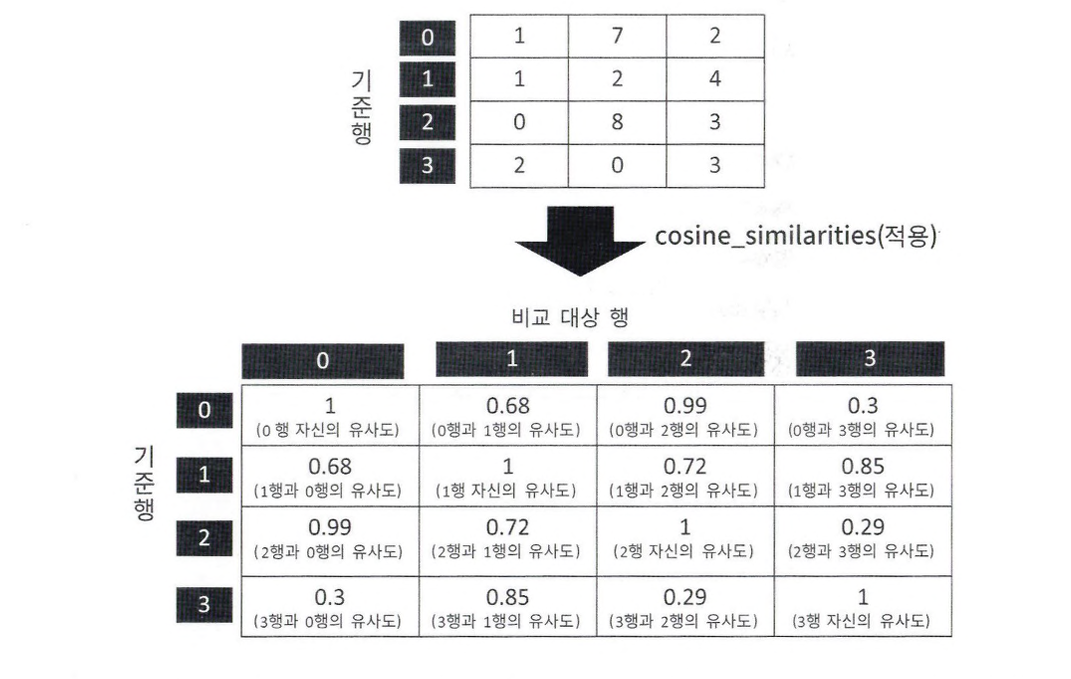

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(4803, 4803)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [11]:
# 행별로 비교 대상이 되는 행의 유사도 값이 높은 순으로 행렬의 위치 인덱스 값 추추
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[  46 3494  870 ... 3174 3175 3166]]


#### **장르 콘텐츠 필터링을 이용한 영화 추천**


In [12]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
    title_movie = df[df['title']==title_name]

    # title_name을 가진 DataFrame의 index 객체를 ndarray로 반환
    # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]

    # 추출된 top_n index 출력. top_n index는 2차원 데이터
    # dataframe에서 index로 사용하기 위해 1차원 array로 변경
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)

    return df.iloc[similar_indexes]

In [13]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title','vote_average']]

[[4217 2731  281 3866 1243 3636 1464 3337 1149 1847]]


,title,vote_average
4217,Kids,6.8
2731,The Godfather: Part II,8.3
281,American Gangster,7.4
3866,City of God,8.1
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1464,Black Water Transit,0.0
3337,The Godfather,8.4
1149,American Hustle,6.8
1847,GoodFellas,8.2


In [15]:
# 더 많은 후보군 선정 후 영화의 평점에 따라 필터링하여 최종 추천
# vote_average 값 이용
movies_df[['title','vote_average','vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
4662,Little Big Top,10.0,1
3519,Stiff Upper Lips,10.0,1
4045,"Dancer, Texas Pop. 81",10.0,1
4247,Me You and Five Bucks,10.0,2
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
1881,The Shawshank Redemption,8.5,8205
2970,There Goes My Baby,8.5,2
3337,The Godfather,8.4,5893
2796,The Prisoner of Zenda,8.4,11


평가 횟수가 매우 작은 영화가 높은 평점으로 평가되어있어 왜곡 가능성이 있다. 따랏, 새로운 평가 방식이 필요하다.

유명한 평점 사이트인 IMDB에서는 평가 횟수에 대한 가중치가 부여된 평점 방식을 사용한다.

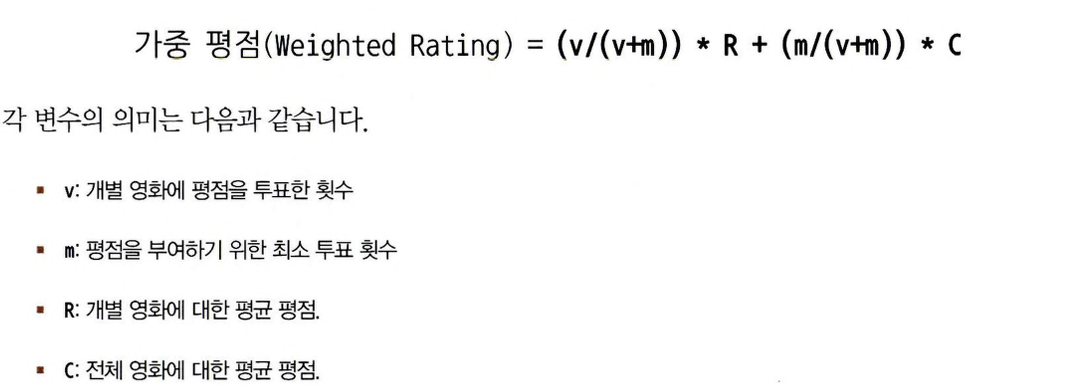

In [16]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:',round(C,3), 'm:', round(m,3))

C: 6.092 m: 370.2


In [17]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']

    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )

movies_df['weighted_vote'] = movies.apply(weighted_vote_average, axis=1)

In [20]:
movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


In [21]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title']==title_name]
    title_index = title_movie.index.values

    # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)

    # 기준 영화 인덱스는 제외
    similar_indexes = similar_indexes[similar_indexes != title_index]

    # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
    return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title','vote_average','weighted_vote']]

,title,vote_average,weighted_vote
1881,The Shawshank Redemption,8.5,8.396052
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
2582,The Place Beyond the Pines,6.8,6.670483
1243,Mean Streets,7.2,6.626569


## **아이템 기반 최근접 이웃 협업 필터링 실습**

### **데이터 가공 및 변환**

In [22]:
import numpy as np
import pandas as pd

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


ratings.csv 는 사용자별로 영화에 대한 평점을 매긴 데이터 세트이다. 협업 필터링은 사용자와 아이템 간의 평점에 기반해 추천하는 시스템이다.

먼저 row 레벨 형태의 원본 데이터 세트를 다음 그림과 같이 모든 사용자를 row로, 모든 영화를 column으로 구성한 데이터 세트로 변경해야 한다.

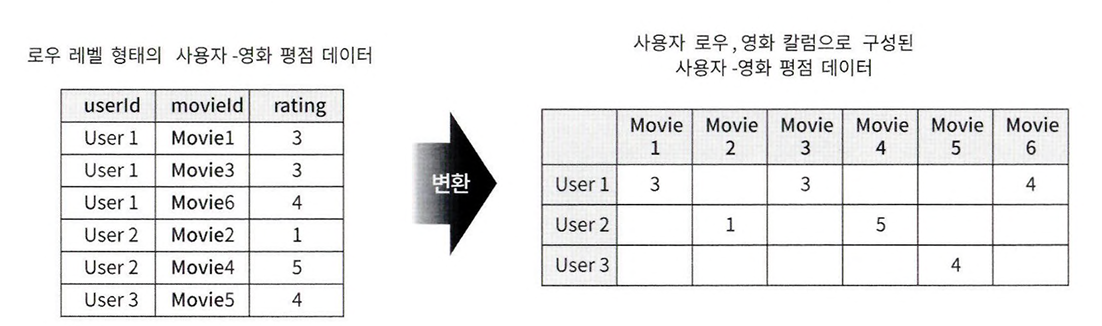

이와 같은 변환은 pivot_table( ) 함수를 이용하면 쉽게 할 수 있다. 해당 함수는 row 레벨의 값을 칼럼으로 변경하는 데 효과적이다.

In [23]:
ratings = ratings[['userId','movieId','rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# title 칼럼을 얻기 위해 movies와 join
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title'로 title 칼럼 피벗 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **영화 간 유사도 산출**

영화를 기준으로 cosine_similarity( )를 적용하려면 현재의 ratings_matrix가 행 기준이 영화가 되고 열 기준이 사용자가 되어야 한다.

In [28]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity( )로 반환된 넘파이 행렬을 영화명을 매핑해 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                           columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [30]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[:6]

,"Godfather, The (1972)"
title,
"Godfather, The (1972)",1.000000
"Godfather: Part II, The (1974)",0.821773
Goodfellas (1990),0.664841
One Flew Over the Cuckoo's Nest (1975),0.620536
Star Wars: Episode IV - A New Hope (1977),0.595317
Fargo (1996),0.588614


In [31]:
item_sim_df["Inception (2010)"].sort_values(ascending=False)[:6]

,Inception (2010)
title,
Inception (2010),1.000000
"Dark Knight, The (2008)",0.727263
Inglourious Basterds (2009),0.646103
Shutter Island (2010),0.617736
"Dark Knight Rises, The (2012)",0.617504
Fight Club (1999),0.615417


만들어진 아이템 기반 유사도 데이터는 사용자의 평점 정보를 모두 취합해 영화에 따라 유사한 다른 영화를 추천할 수 있게 해준다.

### **아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천**

개인화된 영화 추천의 가장 큰 특징은 개인이 아직 관림하지 않은 영화를 추천한다는 것이다. 아직 관람하지 않은 영화에 대해서 아이템 유사도와 기존에 관람한 영화의 평점 데이터를 기반으로 해 새롭게 모든 영화의 예측 평점을 계산한 후 높은 예측 평점을 가진 영화를 추천하는 방식이다.

아이템 기반의 협업 필터링에서 개인화된 예측 평점은 다음 식으로 구할 수 있다.

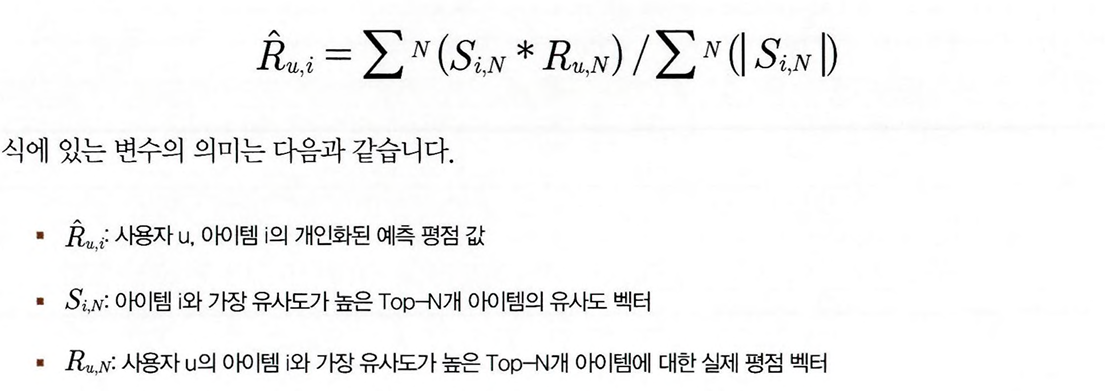

사용자별로 최적화된 평점 스코어를 예측하는 함수를 만들어보자. 인자로 사용자-영화 평점 넘파이 행렬과 영화 간의 유사도를 가지는 넘파이 행렬을 입력받고 이를 이용해 개인화된 예측 평점을 계산한다.

In [34]:
def predict_rating(rating_arr, item_sim_arr):
    ratings_pred = rating_arr.dot(item_sim_arr)/np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred

In [35]:
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index,
                                   columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


이 예측 결과가 원래 실제 평점과 얼마나 차이가 있는지 확인해보기 위해 MSE를 적용한다. MSE를 계산할 때는 사용자가 평점을 부여한 영화에 대해서만 구하는 것을 유의해야 한다.

In [36]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE를 구함
def get_mse(pred, actual):
    # 평점이 있는 영화만 추출
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

print('아이템 기반 모든 최근접 이웃 MSE:',
      get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근접 이웃 MSE: 9.895354759094706


In [42]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
  # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
  pred = np.zeros(ratings_arr.shape)

  # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행
  for col in range(ratings_arr.shape[1]):
    # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
    top_n_items = [np.argsort(item_sim_arr[:,col])[:-n-1:-1]]
    # 개인화된 예측 평점을 계산
    for row in range(ratings_arr.shape[0]):
      pred[row, col] = item_sim_arr[col,:][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
      pred[row, col] /= np.sum(np.abs(item_sim_arr[col,:][top_n_items]))

  return pred

In [43]:
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=20)
print('아이템 기반 최근접 Top-20 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values))

# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index,
                                   columns=ratings_matrix.columns)

아이템 기반 최근접 Top-20 이웃 MSE:  3.694409449382562


In [44]:
user_rating_id = ratings_matrix.loc[9,:]
user_rating_id[user_rating_id > 0].sort_values(ascending=False)[:10]

,9
title,
Adaptation (2002),5.0
Austin Powers in Goldmember (2002),5.0
Back to the Future (1985),5.0
Citizen Kane (1941),5.0
"Lord of the Rings: The Fellowship of the Ring, The (2001)",5.0
"Lord of the Rings: The Two Towers, The (2002)",5.0
"Producers, The (1968)",5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),5.0
Elling (2001),4.0


In [45]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환함.
    # 반환된 user_rating은 영화명(title)을 인덱스를 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId, :]

    #user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듦.
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듦.
    movies_list = ratings_matrix.columns.tolist()

    # list comporehension으로 already_seen에 해당하는 영화는 movies_list에서 제외함.
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list

In [46]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n = 10):
    # 예측 평점 DataFrame에서 사용자id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 최근접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index,
                             columns=['pred_score'])

recomm_movies


,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591
